In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general libraries
import glob
import os
import pathlib
import site
import re
import sys
import warnings
from loguru import logger
# data handling libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
from tqdm.dask import TqdmCallback as ProgressBarDask
from tqdm.notebook import tqdm as ProgressBar
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning libraries
import gpytorch
from sklearn import gaussian_process as gp
import torch

import cryogrid_pytools as cg
import pamir_mlpermafrost as pamir

In [ ]:
path_output = pathlib.Path("../../../pamir-CryoGrid/output/")
fnames = sorted(path_output.glob("*.zarr"))

# matches anything between hyphens or underscores
for fname in fnames:
    ds = xr.open_zarr(fname, consolidated=True)
    break

In [26]:
# we choose seasons shifted by one month, since warmest period is from July to September - needed for thermal depth
bins   = [0.5, 3.5, 6.5, 9.5, 12.5]
labels = ["JFM", "AMJ", "JAS", "OND"]

with ProgressBarDask():
    temp_profiles = (
        ds['temperature']
        .sel(depth=slice(-0.05, -20))
        .groupby_bins("time.month", bins=bins, labels=labels)
        .quantile([0.10, 0.5, 0.90])
        .rename(month_bins='season')
        .compute()
    )

  0%|          | 0/15001 [00:00<?, ?it/s]

# Description of problem and solution:

Problem with using quantiles is that our profiles are not stationary over time, i.e., there is sometimes a small shift in deep temperatures. We want to adjust our profile stats so that all temperatures at depth are stationary (0 change between quantiles and seasons). In other words, we want to represent a mean state for the 2000-2024 period, but we're interested in seasonal variability above that mean state.

We do this with the following steps:

1. Exclude profiles that have a large standard deviation at depth based on a threshold
   1. Compute the standard deviation over [quantile, season] for each profile below 15m depth
   2. Use a Generalized Extreme Value (GEV) distribution to find a threshold for the standard deviation (e.g., 95% quantile)
   3. exclude profiles where the mean standard deviation of temperature below 15m is above the threshold

2. Adjust profiles to median reference temperature at depth by doing the following for each profile:
    1. Create the reference temperature by taking the median of the temperature at depth (e.g., 19-20m) across all seasons and use the median quantile profile as the reference. 
    2. Compute an offset for each profile to the reference temperature at depth 
    3. Subtract the offset from the profile to adjust it to the reference temperature at depth

In [43]:
def get_gev_quantile(arr, q=0.99):
    """
    Fit a Generalized Extreme Value (GEV) distribution to the data and return the quantile at q.
    """
    from scipy.stats import genextreme as gev

    arr = arr[(arr != 0) & ~np.isnan(arr)]  # remove zeros and NaNs
    
    # Fit GEV (SciPy uses shape 'c' = -xi)
    c, loc, scale = gev.fit(arr)  # MLE
    x_q = gev.ppf(q, c, loc, scale)  # quantile function

    return x_q


sigma_temp_deep = temp_profiles.sel(depth=slice(-15, -20)).std(['quantile', 'season'])

thresh = get_gev_quantile(sigma_temp_deep.values, q=0.95)

deep_stable_temp = sigma_temp_deep.mean('depth') < thresh
good_profiles = temp_profiles.sel(tag=deep_stable_temp.values)

# y, x, bars = sigma_temp_deep.plot.hist(bins=50)
# plt.axvline(thresh, color='red', linestyle='--', label=f'GEV 95% quantile: {thresh:.2f}')

/Users/luke/Work/PAMIR/pamir-MLpermafrost/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [45]:
deep_temp_mean = good_profiles.sel(depth=slice(-19, -20)).median(['depth', 'season'])
ref = deep_temp_mean.sel(quantile=0.5)
deep_temp_offset = deep_temp_mean - ref
profiles_corrected = good_profiles - deep_temp_offset

profiles_low_std = (profiles_corrected.sel(depth=-20).std(['season', 'quantile']) < 0.1)
assert profiles_low_std.all(), "Not all profiles have low standard deviation at -20m depth."

In [128]:
def plot_profile(temp_profiles, ax=None):
    sns.set_palette('twilight_shifted', n_colors=12)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 7), dpi=200, facecolor='.12')
    else:
        fig = ax.figure

    x = temp_profiles.stack(profiles=('season', 'quantile'))
    y = x.depth
    tag = x.tag.item()

    ax.plot(x, y)
    ax.axvline(0, color='grey', linestyle='--', linewidth=0.5)

    ax.set_ylim(-20, 0)

    ax.set_title(f'Temperatures at #{tag}', loc='left')
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Temperature [°C]')
    ax.set_facecolor('none')

    fig.tight_layout()

    return fig, ax, tag

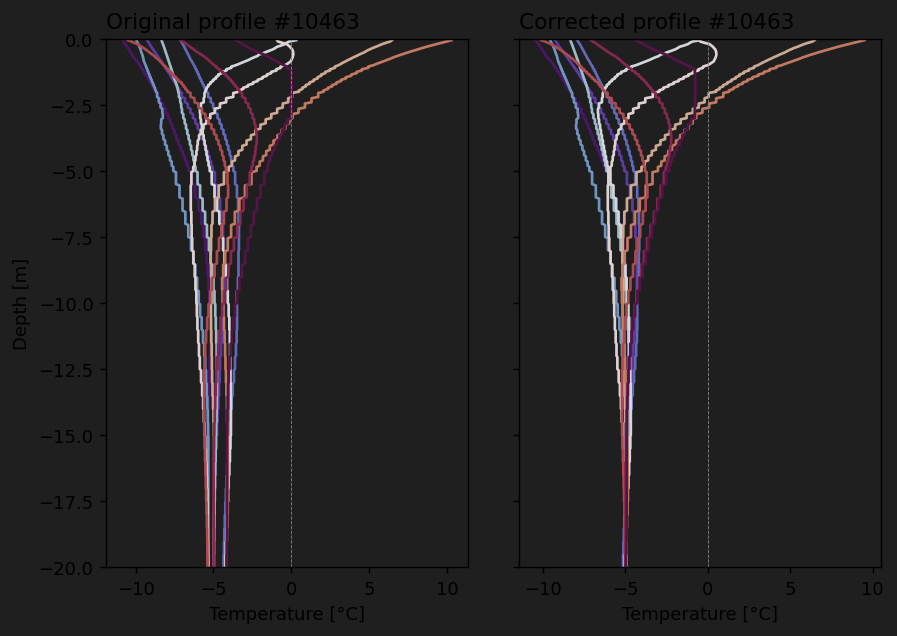

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), dpi=130, facecolor='.12', sharey=True)
_, _, tag = plot_profile(profiles_corrected[443], ax=axs[1])
_, _, tag = plot_profile(temp_profiles.sel(tag=tag), ax=axs[0])

axs[1].set_ylabel('')
axs[0].set_title(f'Original profile #{tag}', loc='left')
axs[1].set_title(f'Corrected profile #{tag}', loc='left')

fig.savefig(f'./imgs/temp_profile_{tag}.png', dpi=130, bbox_inches='tight', transparent=True)